In [1]:
import numpy as np
import pandas as pd
import shapefile as shp
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas
import descartes
import pandas_profiling as pp
from geopandas.tools import overlay

In [2]:
data_file_crime = "Data/Chi_Crimes2018_Food.csv"
chicago_crime = pd.read_csv(data_file_crime)
chicago_crime.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Longitude,Location,Historical Wards 2003-2015,Zip Codes,Community Areas,Census Tracts,Wards,Boundaries - ZIP Codes,Police Districts,Police Beats
0,11553488,JC101094,12/31/2018 23:45,032XX N SHEFFIELD AVE,890,THEFT,FROM BUILDING,BAR OR TAVERN,False,False,...,-87.654124,"(41.940518859, -87.6541242)",38.0,"4,449",57.0,731.0,25.0,22.0,5.0,28.0
1,11555436,JC103293,12/31/2018 22:45,013XX W MADISON ST,890,THEFT,FROM BUILDING,RESTAURANT,False,False,...,-87.661025,"(41.881553034, -87.661024778)",41.0,"14,917",29.0,91.0,46.0,44.0,15.0,92.0
2,11552507,JB574323,12/31/2018 19:00,006XX N CLARK ST,890,THEFT,FROM BUILDING,RESTAURANT,False,False,...,-87.631155,"(41.892694268, -87.631154519)",22.0,"4,446",37.0,670.0,36.0,55.0,14.0,72.0
3,11552368,JB574163,12/31/2018 18:50,012XX S ASHLAND AVE,860,THEFT,RETAIL THEFT,GROCERY FOOD STORE,True,False,...,-87.666379,"(41.866331725, -87.666379171)",48.0,"14,920",29.0,96.0,23.0,43.0,15.0,150.0
4,11552547,JB574146,12/31/2018 18:29,0000X W 87TH ST,860,THEFT,RETAIL THEFT,GROCERY FOOD STORE,False,False,...,-87.627768,"(41.736269116, -87.627768243)",18.0,"21,554",40.0,1.0,13.0,59.0,20.0,242.0


In [3]:
#chicago_crime["Location"] = 'POINT ' + chicago_crime["Location"].astype(str)
#chicago_crime.head()

In [41]:
chicago_fast_food = chicago_fast_food.rename(columns={"CENSUS TRACT": "CENSUS_TRACT"})

In [37]:
data_file = "Data/Map_of_Grocery_Stores_-_2013.csv"
chicago_fast_food = pd.read_csv(data_file)

df_c["CENSUS_TRACT"] = df_c["CENSUS_TRACT"].astype(int)

In [46]:
chicago_fast_food.merge(df_c, how="left", on="CENSUS_TRACT")
#df_c.profile_report(style={'full_width':True})

,STORE NAME,LICENSE ID,ACCOUNT NUMBER,SQUARE FEET,BUFFER SIZE,ADDRESS,ZIP CODE,COMMUNITY AREA NAME,COMMUNITY AREA,WARD,...,:@computed_region_awaf_s7ux,commarea,commarea_n,countyfp10,name10,namelsad10,notes,statefp10,tractce10,coords
0,BOB'S LIQUORS & GROCERIES,957.0,86492.0,10001.0,A,5069 W MADISON ST,60644,AUSTIN,25,28,...,11,25,25.0,031,2522.01,Census Tract 2522.01,,17,252201,"[(-87.74936500001877, 41.879000000011295), (-8..."
1,QUICK STOP FOOD MART,39791.0,3604.0,3000.0,B,2751 W PRATT BLVD,60645,WEST RIDGE,2,50,...,42,2,2.0,031,206.01,Census Tract 206.01,,17,020601,"[(-87.69738400002892, 42.00489299997152), (-87..."
2,DOMINICK'S #147/1147,41674.0,5033.0,68000.0,A,1340 S CANAL ST,60607,NEAR WEST SIDE,28,2,...,48,28,28.0,031,8419,Census Tract 8419,,17,841900,"[(-87.65085700002686, 41.86096499998457), (-87..."
3,CERMAK PRODUCE,1515206.0,279468.0,25000.0,A,5220 S PULASKI RD,60632,WEST ELSDON,62,23,...,35,62,62.0,031,6202,Census Tract 6202,,17,620200,"[(-87.73306200000724, 41.796612000017525), (-8..."
4,WHOLE FOODS MARKET,54059.0,86298.0,4501.0,B,3300 N ASHLAND AVE,60657,LAKE VIEW,6,44,...,38,6,6.0,031,625,Census Tract 625,,17,062500,"[(-87.67294100001449, 41.93963900000891), (-87..."
5,PATEL BROS,25338.0,88729.0,5000.0,B,2610 W DEVON AVE,60659,WEST RIDGE,2,50,...,42,2,2.0,031,206.02,Census Tract 206.02,,17,020602,"[(-87.69494699999383, 42.00494699996343), (-87..."
6,OHIO FOOD MART,1225367.0,243092.0,3500.0,B,5345 W OHIO ST,60644,AUSTIN,25,37,...,4,25,25.0,031,2515,Census Tract 2515,,17,251500,"[(-87.75682499995943, 41.89492000000142), (-87..."
7,JOE'S FOOD & LIQUOR,822.0,154.0,3500.0,B,3626 W LAWRENCE AVE,60625,ALBANY PARK,14,39,...,28,14,14.0,031,1403.01,Census Tract 1403.01,,17,140301,"[(-87.72802800000008, 41.968242000024105), (-8..."
8,TWO BLUE FOODS INC,66710.0,20549.0,3000.0,B,702 E 100TH PL,60628,PULLMAN,50,8,...,9,50,50.0,031,5001,Census Tract 5001,,17,500100,"[(-87.585040000014, 41.71766500003189), (-87.5..."
9,JEWEL FOOD STORE #3349,1353385.0,259.0,64285.0,A,2520 N NARRAGANSETT AVE,60639,BELMONT CRAGIN,19,36,...,39,19,19.0,031,8315,Census Tract 8315,,17,831500,"[(-87.78527700001166, 41.91822799997158), (-87..."


In [4]:
chicago_crime_gdf = geopandas.GeoDataFrame(
    chicago_crime, geometry=geopandas.points_from_xy(chicago_crime.Longitude, chicago_crime.Latitude))
chicago_crime_gdf.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Location,Historical Wards 2003-2015,Zip Codes,Community Areas,Census Tracts,Wards,Boundaries - ZIP Codes,Police Districts,Police Beats,geometry
0,11553488,JC101094,12/31/2018 23:45,032XX N SHEFFIELD AVE,890,THEFT,FROM BUILDING,BAR OR TAVERN,False,False,...,"(41.940518859, -87.6541242)",38.0,"4,449",57.0,731.0,25.0,22.0,5.0,28.0,POINT (-87.65412420000001 41.94051886)
1,11555436,JC103293,12/31/2018 22:45,013XX W MADISON ST,890,THEFT,FROM BUILDING,RESTAURANT,False,False,...,"(41.881553034, -87.661024778)",41.0,"14,917",29.0,91.0,46.0,44.0,15.0,92.0,POINT (-87.66102478000001 41.88155303)
2,11552507,JB574323,12/31/2018 19:00,006XX N CLARK ST,890,THEFT,FROM BUILDING,RESTAURANT,False,False,...,"(41.892694268, -87.631154519)",22.0,"4,446",37.0,670.0,36.0,55.0,14.0,72.0,POINT (-87.63115452 41.89269427)
3,11552368,JB574163,12/31/2018 18:50,012XX S ASHLAND AVE,860,THEFT,RETAIL THEFT,GROCERY FOOD STORE,True,False,...,"(41.866331725, -87.666379171)",48.0,"14,920",29.0,96.0,23.0,43.0,15.0,150.0,POINT (-87.66637917 41.86633173)
4,11552547,JB574146,12/31/2018 18:29,0000X W 87TH ST,860,THEFT,RETAIL THEFT,GROCERY FOOD STORE,False,False,...,"(41.736269116, -87.627768243)",18.0,"21,554",40.0,1.0,13.0,59.0,20.0,242.0,POINT (-87.62776823999999 41.73626912)


In [49]:
fast_food_count = chicago_fast_food.groupby("CENSUS_TRACT").count()

In [51]:
fast_food_merge = fast_food_count["STORE NAME"]
fast_food_merge.head()

CENSUS_TRACT
140500         1
670300         1
17031010100    1
17031010202    2
17031010300    1
Name: STORE NAME, dtype: int64

In [62]:
fast_food_df = pd.DataFrame(fast_food_merge)
df_merge = chicago_fast_food.merge(fast_food_merge, how="left", on="CENSUS_TRACT")

In [63]:
chicago_fast_food.columns

Index(['STORE NAME', 'LICENSE ID', 'ACCOUNT NUMBER', 'SQUARE FEET',
       'BUFFER SIZE', 'ADDRESS', 'ZIP CODE', 'COMMUNITY AREA NAME',
       'COMMUNITY AREA', 'WARD', 'CENSUS_TRACT', 'CENSUS BLOCK',
       'X COORDINATE', 'Y COORDINATE', 'LATITUDE', 'LONGITUDE', 'LOCATION',
       'Community Areas', 'Zip Codes', 'Boundaries - ZIP Codes',
       'Census Tracts', 'Wards', ':@computed_region_awaf_s7ux'],
      dtype='object')

In [65]:
df_c.merge(df_merge, how="left", on="CENSUS_TRACT")
df_c.head()

,commarea,commarea_n,countyfp10,CENSUS_TRACT,name10,namelsad10,notes,statefp10,tractce10,coords
0,44,44.0,031,17031842400,8424,Census Tract 8424,,17,842400,"[(-87.62404799998049, 41.73021699998396), (-87..."
1,59,59.0,031,17031840300,8403,Census Tract 8403,,17,840300,"[(-87.6860799999848, 41.82295600001154), (-87...."
2,34,34.0,031,17031841100,8411,Census Tract 8411,,17,841100,"[(-87.62934700001182, 41.8527970000265), (-87...."
3,31,31.0,031,17031841200,8412,Census Tract 8412,,17,841200,"[(-87.68813499997718, 41.85569099999095), (-87..."
4,32,32.0,031,17031839000,8390,Census Tract 8390,,17,839000,"[(-87.63312200003458, 41.87448800002695), (-87..."


In [5]:
chicago_pd = geopandas.read_file("Data/geo_export_a7b0c29f-14bd-45d7-a251-f4277387b6a6.geojson")
chicago_census = geopandas.read_file("Data/Boundaries - Census Tracts - 2010.geojson")
chicago_census.head(100)

,statefp10,name10,commarea_n,namelsad10,commarea,geoid10,notes,tractce10,countyfp10,geometry
0,17,8424,44,Census Tract 8424,44,17031842400,,842400,031,(POLYGON ((-87.62404799998049 41.7302169999839...
1,17,8403,59,Census Tract 8403,59,17031840300,,840300,031,(POLYGON ((-87.6860799999848 41.82295600001154...
2,17,8411,34,Census Tract 8411,34,17031841100,,841100,031,(POLYGON ((-87.62934700001182 41.8527970000265...
3,17,8412,31,Census Tract 8412,31,17031841200,,841200,031,(POLYGON ((-87.68813499997718 41.8556909999909...
4,17,8390,32,Census Tract 8390,32,17031839000,,839000,031,(POLYGON ((-87.63312200003458 41.8744880000269...
5,17,8382,28,Census Tract 8382,28,17031838200,,838200,031,(POLYGON ((-87.66781999997529 41.8741839999791...
6,17,6503.01,65,Census Tract 6503.01,65,17031650301,,650301,031,(POLYGON ((-87.73706400002477 41.7712039999837...
7,17,5305.03,53,Census Tract 5305.03,53,17031530503,,530503,031,(POLYGON ((-87.64386399998179 41.6632100000208...
8,17,7608.03,76,Census Tract 7608.03,76,17031760803,,760803,031,(POLYGON ((-87.83844200004106 41.9701999999708...
9,17,306.01,77,Census Tract 306.01,77,17031030601,,030601,031,(POLYGON ((-87.6543830000042 41.99020200000391...


In [6]:
chicago_pd.head()

,pri_neigh,sec_neigh,shape_area,shape_len,geometry
0,Grand Boulevard,BRONZEVILLE,4.849250e+07,28196.837157,POLYGON ((-87.60670812560372 41.81681377137392...
1,Printers Row,PRINTERS ROW,2.162138e+06,6864.247156,"POLYGON ((-87.62760697485348 41.8743709778537,..."
2,United Center,UNITED CENTER,3.252051e+07,23101.363745,POLYGON ((-87.66706868914602 41.88885187769547...
3,Sheffield & DePaul,SHEFFIELD & DEPAUL,1.048259e+07,13227.049745,POLYGON ((-87.65833494805533 41.92166144229183...
4,Humboldt Park,HUMBOLDT PARK,1.250104e+08,46126.751351,"POLYGON ((-87.74059567509266 41.8878231689323,..."


In [7]:
sns.set(style="whitegrid", palette="pastel", color_codes=True)
sns.mpl.rc("figure", figsize=(10,6))
%matplotlib inline

In [8]:
shp_path_c = "Data/geo_export_ed8adefc-d13e-4894-93ef-3e3309ee864d.shp"
shp_path_n = "Data/Neighborhoods_2012b.shp"
sf_c = shp.Reader(shp_path_c)
sf_n = shp.Reader(shp_path_n)

In [9]:
len(sf_c.shapes())

801

In [10]:
len(sf_n.shapes())

98

In [11]:
sf_c.records()[1]

Record #1: ['59', 59.0, '031', '17031840300', '8403', 'Census Tract 8403', '', '17', '840300']

In [12]:
sf_n.records()[1]

Record #1: ['Printers Row', 'PRINTERS ROW', 2162137.97139, 6864.247156]

In [13]:
''''''
def read_shapefile(sf):
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    return df
''''''

''

In [14]:
df_c = read_shapefile(sf_c)
df_c.shape

(801, 10)

In [15]:
df_n = read_shapefile(sf_n)
df_n.shape

(98, 5)

In [16]:
df_c.head()

,commarea,commarea_n,countyfp10,geoid10,name10,namelsad10,notes,statefp10,tractce10,coords
0,44,44.0,031,17031842400,8424,Census Tract 8424,,17,842400,"[(-87.62404799998049, 41.73021699998396), (-87..."
1,59,59.0,031,17031840300,8403,Census Tract 8403,,17,840300,"[(-87.6860799999848, 41.82295600001154), (-87...."
2,34,34.0,031,17031841100,8411,Census Tract 8411,,17,841100,"[(-87.62934700001182, 41.8527970000265), (-87...."
3,31,31.0,031,17031841200,8412,Census Tract 8412,,17,841200,"[(-87.68813499997718, 41.85569099999095), (-87..."
4,32,32.0,031,17031839000,8390,Census Tract 8390,,17,839000,"[(-87.63312200003458, 41.87448800002695), (-87..."


In [17]:
df_n.head()

,PRI_NEIGH,SEC_NEIGH,SHAPE_AREA,SHAPE_LEN,coords
0,Grand Boulevard,BRONZEVILLE,4.849250e+07,28196.837157,"[(1182322.0428999998, 1876674.7307000011), (11..."
1,Printers Row,PRINTERS ROW,2.162138e+06,6864.247156,"[(1176452.803199999, 1897600.9275999963), (117..."
2,United Center,UNITED CENTER,3.252051e+07,23101.363745,"[(1165664.4825000018, 1902791.8572999984), (11..."
3,Sheffield & DePaul,SHEFFIELD & DEPAUL,1.048259e+07,13227.049745,"[(1167948.4904999994, 1914766.2669999972), (11..."
4,Humboldt Park,HUMBOLDT PARK,1.250104e+08,46126.751351,"[(1145646.625, 1902270.1251000017), (1145645.0..."


In [18]:
'''
def plot_map(sf, x_lim = None, y_lim = None, figsize = (15,15)):
    plt.figure(figsize = figsize)
    id=0
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        plt.plot(x, y, 'k')
        
        if (x_lim == None) & (y_lim == None):
            x0 = np.mean(x)
            y0 = np.mean(y)
            #plt.text(x0, y0, id, fontsize=10)
        id = id+1
    
    if (x_lim != None) & (y_lim != None):     
        plt.xlim(x_lim)
        plt.ylim(y_lim)
'''

"\ndef plot_map(sf, x_lim = None, y_lim = None, figsize = (15,15)):\n    plt.figure(figsize = figsize)\n    id=0\n    for shape in sf.shapeRecords():\n        x = [i[0] for i in shape.shape.points[:]]\n        y = [i[1] for i in shape.shape.points[:]]\n        plt.plot(x, y, 'k')\n        \n        if (x_lim == None) & (y_lim == None):\n            x0 = np.mean(x)\n            y0 = np.mean(y)\n            #plt.text(x0, y0, id, fontsize=10)\n        id = id+1\n    \n    if (x_lim != None) & (y_lim != None):     \n        plt.xlim(x_lim)\n        plt.ylim(y_lim)\n"

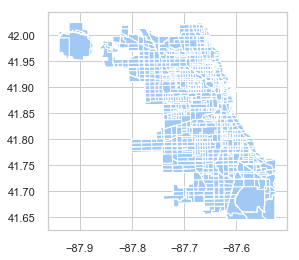

In [19]:
chicago_union = geopandas.overlay(chicago_pd, chicago_census, how="union")
chicago_union.plot()

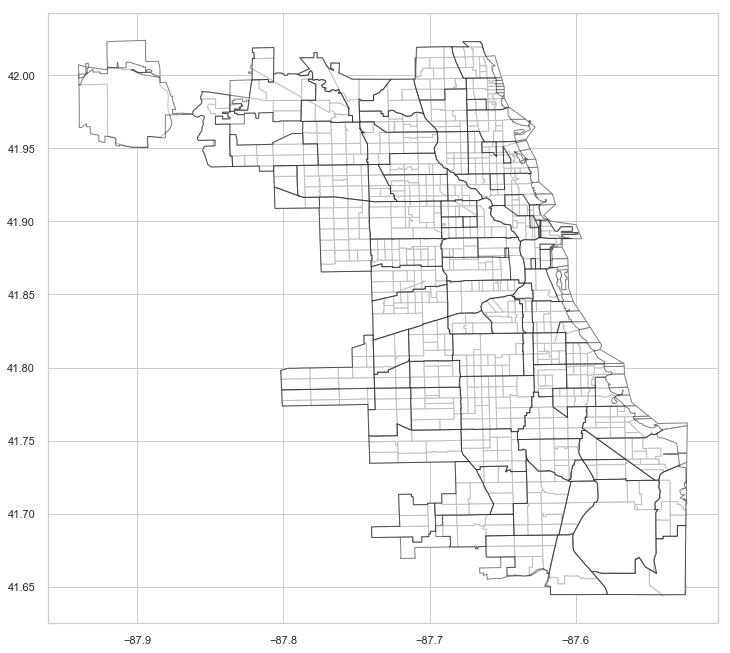

In [20]:
ax = chicago_census.plot(color="white", edgecolor="grey", figsize=(12, 12))
full_map = chicago_pd.plot(ax=ax, alpha=.5, color="white", edgecolor="black", figsize=(12,12));

In [21]:
#chicago_crime_gdf.plot(ax=chicago_union, marker="o", color="red");

AttributeError: 'GeoDataFrame' object has no attribute 'set_aspect'

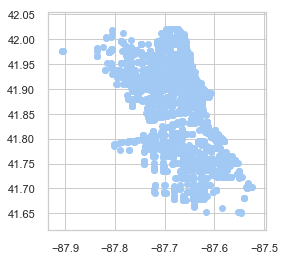

In [22]:
chicago_crime_gdf.plot()

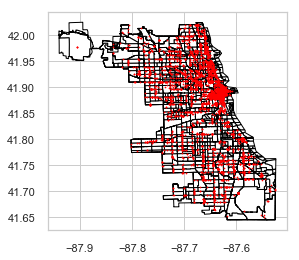

In [23]:
fig, ax = plt.subplots()

ax.set_aspect('equal')
chicago_union.plot(ax=ax, color="white", edgecolor="black")

chicago_crime_gdf.plot(ax=ax, marker="o", color="red", markersize=.5)
plt.show();

In [24]:
#plot_map(sf_c)
#plot_map(sf_n)

In [27]:
df_c.head()

,commarea,commarea_n,countyfp10,geoid10,name10,namelsad10,notes,statefp10,tractce10,coords
0,44,44.0,031,17031842400,8424,Census Tract 8424,,17,842400,"[(-87.62404799998049, 41.73021699998396), (-87..."
1,59,59.0,031,17031840300,8403,Census Tract 8403,,17,840300,"[(-87.6860799999848, 41.82295600001154), (-87...."
2,34,34.0,031,17031841100,8411,Census Tract 8411,,17,841100,"[(-87.62934700001182, 41.8527970000265), (-87...."
3,31,31.0,031,17031841200,8412,Census Tract 8412,,17,841200,"[(-87.68813499997718, 41.85569099999095), (-87..."
4,32,32.0,031,17031839000,8390,Census Tract 8390,,17,839000,"[(-87.63312200003458, 41.87448800002695), (-87..."
